In [1]:
pip install torch transformers matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [20]:
from google.colab import files

uploaded = files.upload()

Saving merged_cleaned_alcon_2022_esg_text_blocks.txt to merged_cleaned_alcon_2022_esg_text_blocks.txt


[🔍] 加载 FinBERT-ESG 模型中...


Device set to use cuda:0


得分 > 0.90 的句子数：371
得分 > 0.85 的句子数：403
非 None 类别句子数：496


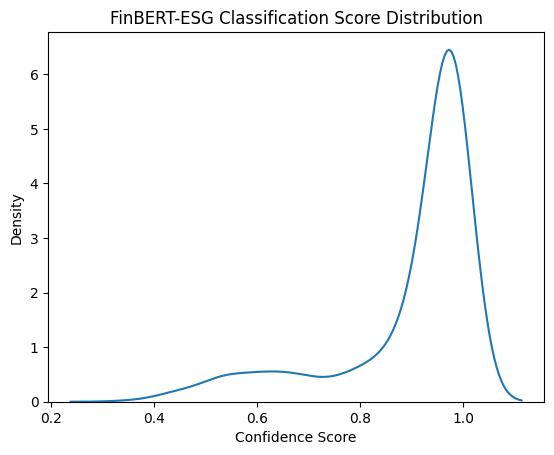

[⚠️] 超长句子数（截断处理）：65
[✅] 筛选完成：原始 586 句 → 保留 371 句
[📁] 已保存至：/content/esg_filtered_text/filtered_merged_cleaned_alcon_2022_esg_text_blocks.txt


In [21]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

input_file_path = "merged_cleaned_alcon_2022_esg_text_blocks.txt"
def get_result_path(input_file_path):
    """输出文件保存路径：/content/esg_filtered_text/"""
    file_dir, file_name = os.path.split(input_file_path)
    file_base, file_ext = os.path.splitext(file_name)
    base_dir = os.path.join("/content", "esg_filtered_text")
    os.makedirs(base_dir, exist_ok=True)
    output_file_path = os.path.join(base_dir, f"filtered_{file_base}.txt")
    return output_file_path


def plot_distribution(results):
    scores = [r[0]['score'] for r in results]
    sns.kdeplot(scores)
    plt.xlabel('Confidence Score')
    plt.title('FinBERT-ESG Classification Score Distribution')
    plt.show()


def see_scores(results, threshold):
    above_t = sum(1 for r in results if r[0]['score'] > threshold and r[0]['label'] != 'None')
    above_t_minus = sum(1 for r in results if r[0]['score'] > threshold - 0.05 and r[0]['label'] != 'None')
    non_none = sum(1 for r in results if r[0]['label'] != 'None')
    print(f"得分 > {threshold:.2f} 的句子数：{above_t}")
    print(f"得分 > {threshold - 0.05:.2f} 的句子数：{above_t_minus}")
    print(f"非 None 类别句子数：{non_none}")


def filter_text(input_file_path, threshold=0.9, max_len=510, view=False):
    print("[🔍] 加载 FinBERT-ESG 模型中...")
    model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-esg", num_labels=4)
    tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-esg")
    device = 0 if torch.cuda.is_available() else -1
    nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)

    output_file_path = get_result_path(input_file_path)
    with open(input_file_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]

    results, too_long = [], []

    for line in lines:
        if len(line) > 512:
            result = nlp(line[:max_len])
            too_long.append(line)
        else:
            result = nlp(line)
        results.append(result)

    if view:
        see_scores(results, threshold)
        plot_distribution(results)
        print(f"[⚠️] 超长句子数（截断处理）：{len(too_long)}")

    filtered = [lines[i] for i in range(len(lines))
                if results[i][0]['label'] != 'None' and results[i][0]['score'] > threshold]

    with open(output_file_path, 'w', encoding='utf-8') as f:
        for line in filtered:
            f.write(line + '\n')

    print(f"[✅] 筛选完成：原始 {len(lines)} 句 → 保留 {len(filtered)} 句")
    print(f"[📁] 已保存至：{output_file_path}")

filter_text(input_file_path, threshold=0.9, view=True)


In [22]:
from google.colab import files

# 改成你日志打印出的完整路径
filtered_text_path = "/content/esg_filtered_text/filtered_merged_cleaned_alcon_2022_esg_text_blocks.txt"

files.download(filtered_text_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>